# CDL preprocessing - Spatial model 

In this notebook we process the CDL rescaled for groups A (training) and B (testing). To have the percentage from the **NASS statistics** and the correct format to become the target for the **CDL calibrated model**. 


By this point the rescaling process was already made in QGIS for all available years of the CDL (2008 - 2021). Wich gives us 14 years of data, 14 layers to process. For each year we have 241 counties. The split for A and B is 80% and 20% respectively.  That gives us 193 counties for A and 48 for B, as shown in the next figure. 
 

<img src="images/ABgroups.jpg" alt="Drawing" style="width: 300px; height: 290px;"/>

The assignment of the counties to the groups A and B was done randomly. By generating 48 random numbers in the interval [1, 241] and assigning them by the ID column in the propriety’s table of the shape file. 
The processing steps are the following:
- 1: Clip the CDL data with the shapefiles of the counties
- 2: Calibrate the clip data to match the NASS statistics for each county
- 3: Reshape the data to match input of MODIS 
- 4: Tuple the training data (MODIS) with this new "target"
This process needs to be applied separately to each group, because the way we made the split of the counties is by using different sets of shape files in QGIS. 


In [4]:
countryKey="US_South_spatial" #model info in pylib

startyear=2008
endyear=2021

In [5]:
#libraries 
import numpy as np
import time
import sys, os, imp
import glob
from osgeo import gdal
from PIL import Image
import matplotlib.pyplot as plt
dirname = os.path.dirname("fieldcrop-detection-south")
filename = os.path.join(dirname, 'pyLib')
sys.path.append(filename)
from modis_lib import modisDataConverter as dataConv #main library of fuctions
imp.reload(dataConv)
from modis_lib import anas_functions as aCDL #main library of CDL preprossesing fuctions
imp.reload(aCDL)

from modis_lib import modelDictionary as modelDictionary
imp.reload(modelDictionary)
modelInfo=modelDictionary.getModelData()[countryKey]


hyyywertuuu  ttttteeettt


In [6]:
#Modis data folder for reference
clipped_Files="Preprocessing/modis/DataClipped"
reshaped_Files="Preprocessing/modis/DataReshaped"
stacked_Files="Preprocessing/modis/DataStacked"

######CDL routes:
#palces to save files durig the processing
data_resized = "Preprocessing/CDL/CDL_rescaled" #input
data_clipped = "Preprocessing/CDL/CDL_clipped" #folder to save data cliped
data_reshaped = "Preprocessing/CDL/CDL_reshaped_torch"#folder to saved data reshaped in torch format
data_calibrated = "Preprocessing/CDL/CDL_calibrated"#save data calibrated 

#Info comming from diccionary 
shapefiles = modelInfo["shapefilesAB"] #routes of shape files


countryCode=modelInfo["countryCode"]
img_height=modelInfo["imgHeight"]
img_width=modelInfo["imgWidth"]
#The max height and with sizes come after preproces the MODIS data(input data)

## 1: Clip the CDL data with the shapefiles of the counties

In [28]:
print("start clipping shapes...")
filesToClip=aCDL.getFilesToClip_CDL(startyear,data_resized)#this finds all the CDL layers to clip
#and returns a list with the files 

print("filesToClip:"+str(len(filesToClip)))
#print(shapefiles_A)
filesToClip

start clipping shapes...
filesToClip:14


['Preprocessing/CDL/CDL_rescaled/CDLr.2008.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2009.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2010.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2011.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2012.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2013.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2014.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2015.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2016.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2017.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2018.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2019.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2020.tif',
 'Preprocessing/CDL/CDL_rescaled/CDLr.2021.tif']

In [11]:
for rasterFile in filesToClip:
    aCDL.clipData_CDL(shapefiles,rasterFile,data_clipped,countryCode)
    #This fuction takes a layer, shape files and clips the files 
    #and saves the output in the folder data_cliped

Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US1802.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US1817.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US1819.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2136.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2138.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2139.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2140.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2142.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2143.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2147.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2150.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2151.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2154.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2156.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2157.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2158.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2159.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US2160.tif
Preprocessing/CDL/CDL_clippe

Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US911.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US912.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US913.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US914.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US915.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US916.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US917.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US918.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US919.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US920.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US921.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US922.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US923.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US924.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US925.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US926.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US927.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US928.tif
Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2611.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2613.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2616.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2617.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US262.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2621.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2622.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2624.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2625.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2629.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2630.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2632.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2636.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2640.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2643.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2645.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2653.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US2658.tif
Preprocessing/CDL/CDL_clipped

Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US989.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US990.tif
Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US991.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US1802.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US1817.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US1819.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2136.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2138.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2139.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2140.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2142.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2143.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2147.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2150.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2151.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2154.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2156.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US2157.tif
Preprocessing/CDL/CDL_clipped/C

Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US911.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US912.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US913.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US914.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US915.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US916.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US917.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US918.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US919.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US920.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US921.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US922.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US923.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US924.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US925.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US926.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US927.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US928.tif
Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2616.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2617.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US262.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2621.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2622.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2624.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2625.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2629.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2630.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2632.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2636.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2640.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2643.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2645.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2653.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2658.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2661.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US2664.tif
Preprocessing/CDL/CDL_clipped

Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US990.tif
Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US991.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US1802.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US1817.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US1819.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2136.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2138.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2139.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2140.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2142.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2143.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2147.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2150.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2151.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2154.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2156.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2157.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US2158.tif
Preprocessing/CDL/CDL_clipped/

Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US904.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US905.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US906.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US907.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US908.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US909.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US910.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US911.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US912.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US913.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US914.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US915.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US916.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US917.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US918.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US919.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US920.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US921.tif
Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2585.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2587.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2589.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2591.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2594.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2602.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2603.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2604.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2609.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2611.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2613.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2616.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2617.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US262.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2621.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2622.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2624.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US2625.tif
Preprocessing/CDL/CDL_clipped

Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US980.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US981.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US982.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US983.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US984.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US985.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US986.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US987.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US988.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US989.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US990.tif
Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US991.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US1802.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US1817.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US1819.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US2136.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US2138.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US2139.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.

Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US893.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US894.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US895.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US896.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US897.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US898.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US899.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US900.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US901.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US902.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US903.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US904.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US905.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US906.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US907.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US908.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US909.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US910.tif
Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2567.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2568.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2569.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2570.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2574.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2575.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2577.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2580.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2582.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2584.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2585.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2587.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2589.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2591.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2594.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2602.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2603.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US2604.tif
Preprocessing/CDL/CDL_clippe

Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US965.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US966.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US967.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US968.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US969.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US970.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US971.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US972.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US973.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US974.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US975.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US976.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US977.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US978.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US979.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US980.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US981.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US982.tif
Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2768.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2769.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2770.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2775.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2777.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US2778.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US278.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US291.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US887.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US888.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US889.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US890.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US891.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US892.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US893.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US894.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US895.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US896.tif
Preprocessing/CDL/CDL_clipped/CDLr.2016.

Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2528.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2531.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2532.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2535.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2538.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2543.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2549.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2556.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2559.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2561.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2564.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2565.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2566.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2567.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2568.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2569.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2570.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US2574.tif
Preprocessing/CDL/CDL_clippe

Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US951.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US952.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US953.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US954.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US955.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US956.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US957.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US958.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US959.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US960.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US961.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US962.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US963.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US964.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US965.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US966.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US967.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US968.tif
Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2734.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2735.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2737.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2742.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2743.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2745.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2747.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2749.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2750.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2752.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2768.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2769.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2770.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2775.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2777.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US2778.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US278.tif
Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US291.tif
Preprocessing/CDL/CDL_clipped/

Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2194.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2199.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2203.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2204.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2205.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2209.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2210.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2211.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US241.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US243.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US245.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US246.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US250.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2528.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2531.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2532.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2535.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US2538.tif
Preprocessing/CDL/CDL_clipped/CDL

Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US941.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US942.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US943.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US944.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US945.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US946.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US947.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US948.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US949.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US950.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US951.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US952.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US953.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US954.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US955.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US956.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US957.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US958.tif
Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US9

Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2686.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2691.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2694.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2695.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2697.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2699.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2703.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2705.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2706.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2711.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2714.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2717.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US272.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2723.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2726.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US273.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2734.tif
Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US2735.tif
Preprocessing/CDL/CDL_clipped/

Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2162.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2163.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2164.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2167.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2168.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2170.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2171.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2172.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2176.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2178.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2181.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2186.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2193.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2194.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2199.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2203.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2204.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US2205.tif
Preprocessing/CDL/CDL_clippe

Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US930.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US931.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US932.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US933.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US934.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US935.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US936.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US937.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US938.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US939.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US940.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US941.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US942.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US943.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US944.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US945.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US946.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US947.tif
Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US9

## 2: Calibrate the clip data to match the NASS statistics
Now we have the CDL data cut into the shape of the counties. So, we can proceed with the calibration.
-  First we need to find the statistic that corresponds to that county in that year of the CDL clipped. 
- Then we need to calibrate it


The function **getLabelsFromCSV** takes a .csv (excel) file wich contains the statistics for all the USA counties for all the years, takes also the names of the countys of interest from the shape files. And it gives us back a list of all the statistics for the countys found in the shape files with the % of covererage for the selected years. 

In [35]:
241*14

3374

In [36]:
2446 + 241

2687

In [37]:
statistics="statistics/STATS_US_ALL_WHEAT_2000_2021_fixed.csv" #folder with the NASS statistics

stats = dataConv.getLabelsFromCSV(statistics, shapefiles ,
                          startyear,endyear, minPercentage=-1,
                          printNotFound=False)

allShapes: 241
241 shapes
18185 csvtuples
Labels: 2633


In [38]:
#CDL_clip_stats function tupples CDLclipped files with their corresponding NASS statistics
stats_CDL = aCDL.CDL_clip_stats(stats, data_clipped, countryCode)

stats_CDL[0]

['Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2018.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2017.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2016.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2015.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2014.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2013.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2012.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2011.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2010.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2009.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US241.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2021.US.US243.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2020.US.US243.tif',
 'Preprocessing/CDL/CDL_clipped/CDLr.2019.US.US243.tif',
 'Preprocessing/CDL/CDL_clipped

Now we have a list of the CDL clipped files with their corresponding % from the statistics.

So now, we have to calibrate the CDL to match this persentage.

## Calibration

**add mathematical description of process!!!!**

The fuction **calibrate_CDL** takes a double list of files to calibrate with their correct % of coverage and saves the calibrated images in the folder provided.



In [39]:
import os
 
# Specify path
path = 'Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US962.tif'
 
# Check whether the specified
# path exists or not
isExist = os.path.exists(path)
print(isExist)

True


In [40]:
import tifffile
qq = tifffile.imread("Preprocessing/CDL/CDL_clipped/CDLr.2008.US.US962.tif") 
type(qq)

numpy.ndarray

In [49]:
lists_calibration = aCDL.calibrate_CDL(stats_CDL, data_calibrated)

chavacanooooooo :)
Done :)


## Calibration info and analisys

In [50]:
#save the output of the fuction on this variables
constants = lists_calibration[0] 
original_persent = lists_calibration[1]
cdl_percent = lists_calibration[2] 
cdl_percent_norm = lists_calibration[3] 
dif = lists_calibration[4] 
average_cdl_prev = lists_calibration[5] 
average_cdl_post = lists_calibration[6]

### CDL and NASS comparation of %coverage

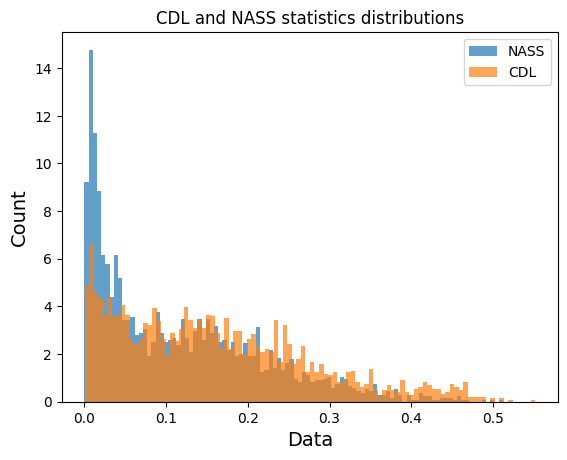

In [52]:
plt.hist(original_persent, density=True, bins=100, alpha=0.7, label="NASS") 
plt.hist(cdl_percent, density=True, bins=100, alpha=0.7, label="CDL") 
plt.title("CDL and NASS statistics distributions")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

### Calibration constants distribution

If the NASS statistics and the CDL values were equal or around equal we should expect a distribution arround the value 1. 

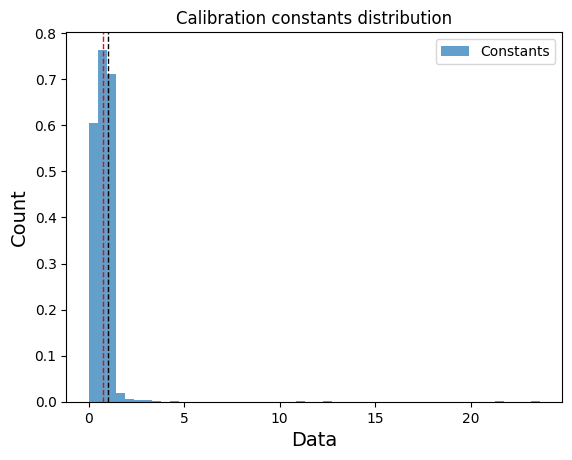

mean = 0.7571362131462667
std = 0.8064647525346909


In [53]:
plt.hist(constants, density=True, bins=50, alpha=0.7, label="Constants")  
plt.title("Calibration constants distribution")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(constants), color='r', linestyle='dashed', linewidth=1)
plt.show()
print("mean =", np.mean(constants))
print("std =", np.std(constants))

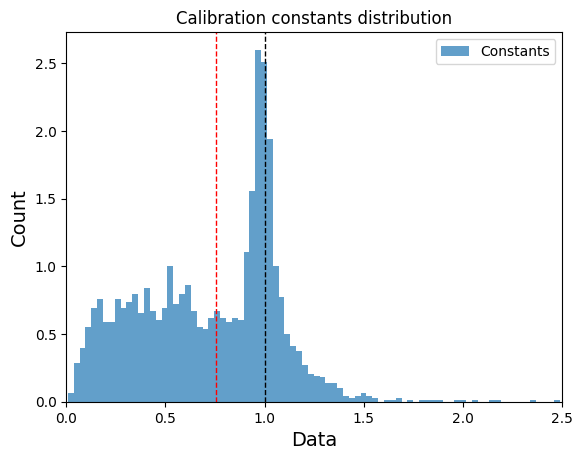

mean = 0.7571362131462667
std = 0.8064647525346909


In [96]:
plt.hist(constants, density=True, bins=800, alpha=0.7, label="Constants")  
plt.title("Calibration constants distribution")
plt.xlim(0,2.5) 
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(constants), color='r', linestyle='dashed', linewidth=1)
plt.show()
print("mean =", np.mean(constants))
print("std =", np.std(constants))



### Difference
We plot the hist of this difference:
dif = NASS - CDLcalibrated

Dif should be equal to 0.  
Just to see if the calibration worked as expected.


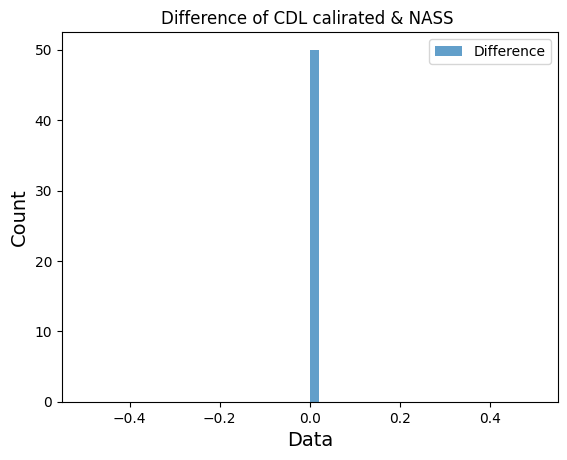

In [54]:
plt.hist(dif, density=True, bins=50, alpha=0.7, label="Difference")  
plt.title("Difference of CDL calirated & NASS ")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

### CDL calibrated and NASS comparation

Another way to make sure that the calibration worked as expected:

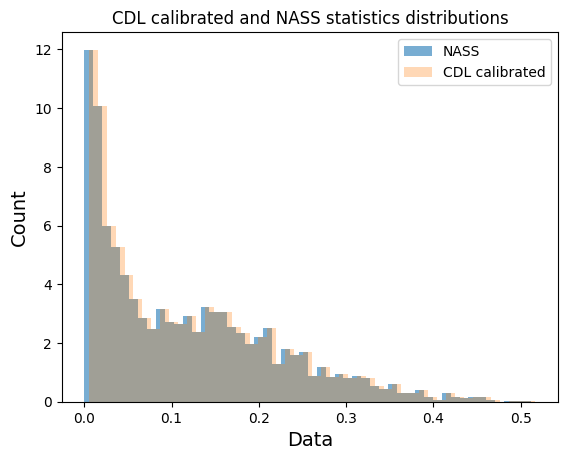

In [55]:
#add a little shipt to visualize the histograms
#they overlap to much = good news = they are equal 
average_cdl_prev_plot = []
for i in average_cdl_prev:
    average_cdl_prev_plot.append(i + .005)

plt.hist(original_persent, density=True, bins=50, alpha=0.6, label="NASS") 
plt.hist(average_cdl_prev_plot, density=True, bins=50, alpha=0.3, label="CDL calibrated") 
plt.title("CDL calibrated and NASS statistics distributions")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

# 3: Pading Reshape

For reshaping we must first find max high and with of all files. 

In [7]:
#data_clipped = "Preprocessing/CDL_preprocessing/CDL_clipped"
Max = aCDL.getMaxFileSizeAuto_CDL(data_clipped)

Check max Filesize
checking 241 Files. This probably takes some time...
max. height:
544
max. width:
993


In [4]:
#reshape:
aCDL.cdl_pad(data_calibrated  , data_reshaped, 544, 993) #for group A

all filles: 2633
Done pytorch!


In [4]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant',constant_values=(-1))


def cdl_pad_notorch(in_route, out_route, x, y):
    """
    This fuction takes one folder with files, resize them into the size(x,y)
    and write the output in the other provided folder
    Input:
    - in_route: folder with files to transform
    - out_route: folder to write files
    - x: size of new width
    - y: size of new high
    """
    
    allFiles=glob.glob(in_route+"/*.txt")#finds all the files to reshape
    allFiles = [s.replace('\\', '/') for s in allFiles] #just in case windows do wierd stuff with paths
    print("all filles:", len(allFiles))

    for i in allFiles:
        cdl = np.loadtxt(i) #load file
        cdl = padding(cdl, x, y)#reshape it
        #cdl = cdl.reshape((1,x,y)) #to match torch convention (chanel,high,width)
        #print(cdl.shape)
        index=i.find("CDLr") ## give it a new name
        re=i[index:]
        re=re.split(".")

        outname = "resh." +re[0]+"."+re[1]+"." + re[2]+"."+re[3]
        #cdl_torch = torch.from_numpy(cdl)

        #torch.save(cdl_torch, out_route + "/" + outname + ".pt")
        
        cdl = Image.fromarray(cdl)
        cdl.save(out_route + "/" + outname + ".tif")
        #np.savetxt(out_route + "/" + outname  , a) #save it
    print("Done no pytorch!")

In [5]:
folder_cdl = "Preprocessing/CDL/cdl_pad_calibrated"
in_folder = "Preprocessing/CDL/CDL_clipped"
#in data calibrated 

In [7]:
cdl_pad_notorch(data_calibrated, folder_cdl,544, 993 )

all filles: 2633
Done no pytorch!


## 4: Tuple to corresponding training point 

The function **getFilesFromLabels_trianingCDL** takes a list of counties in different years with their corresponding value of coverage%, and folders to look for coincidences. If the files are found it returns lists with the data in ordered (train, target, coverage %). 

In [71]:
Train_target = aCDL.getFilesFromLabels_trianingCDL(stats, stacked_Files,
                                                   data_reshaped, countryCode)
####First preproces MODIS

In [72]:
len(Train_target[0]) == len(Train_target[1]) == len(Train_target[2])

True

In [73]:
len(Train_target[0])

2633